# Training Classifier Models and Outlier Detection

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
from lightgbm import LGBMClassifier
from isotree import IsolationForest
from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append("../")

import cfmining.models as models
from cfmining.utils import OutlierWrap
import matplotlib.pyplot as plt

import os
import joblib

%load_ext autoreload
%autoreload 2

## General Configs

In [2]:
VAL_RATIO = 1/10
TEST_RATIO = 0.5
SEED = 0

In [3]:
hyperparam_spaces = {
    "LGBMClassifier": {
        "n_estimators": {"low": 5, "high": 250, "type": "int"},
        "learning_rate": {"low": 0.05, "high": 1.0, "type": "float"},
        "max_depth": {"low": 2, "high": 12, "type": "int"},
        "colsample_bytree": {"low": 0.1, "high": 1.0, "type": "float"},
        "reg_alpha": {"low": 1e-3, "high": 1e3, "log": True, "type": "float"},
        "verbose": {"choices": [-1], "type": "categorical"},
        "random_state" : {"choices": [SEED], "type": "categorical"},
    },
    "MLPClassifier": {
        "hidden_layer_sizes": {
            "choices": [
                [30],
                [30, 30],
                [30, 30, 30],
                [64],
                [30, 64],
            ],
            "type": "categorical",
        },
        "learning_rate_init": {"low": 1e-5, "high": 1e-3, "type": "float", "log": True},
        "epochs": {"low": 10, "high": 100, "type": "int", "step": 10},
        "class_weight": {"choices": ["balanced"], "type": "categorical"},
        "batch_size" : {"low" : 128, "high" : 128, "type" : "int"},
        "random_state" : {"choices": [SEED], "type": "categorical"},
    },
}

In [4]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(
    trial,
    hyperparams,
    X_train,
    Y_train,
    X_val,
    Y_val,
    model_name = "LGBMClassifier"
    ):
    params = {}
    for k, v in hyperparams.items():
        if v["type"] == "categorical":
            params[k] = trial.suggest_categorical(k, v["choices"])
        elif v["type"] == "int":
            params[k] = trial.suggest_int(k, v["low"], v["high"])
        elif v["type"] == "float":
            params[k] = trial.suggest_float(k, v["low"], v["high"], log=v.get("log", False))

   

    if model_name == "LGBMClassifier":
        model = LGBMClassifier(**params)
    elif model_name == "MLPClassifier":
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("classifier", models.MLPClassifier(**params))
        ])
    model.fit(X_train, Y_train)

    Y_val_pred = model.predict(X_val)
    score = balanced_accuracy_score(Y_val, Y_val_pred)

    return score

## German

In [5]:
os.makedirs("../models/german", exist_ok=True)

In [6]:
df = pd.read_csv("../data/german.csv")
X = df.drop("GoodCustomer", axis=1)
Y = df["GoodCustomer"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_RATIO, random_state=SEED, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=VAL_RATIO, random_state=SEED, shuffle=True)

# reset index
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
Y_val = Y_val.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)

In [7]:
for model_name in [
    #"LGBMClassifier", 
    "MLPClassifier"
    ]:
    study = optuna.create_study(
       direction="maximize",
    )
    study.optimize(
        lambda trial: objective(trial, hyperparam_spaces[model_name], X_train, Y_train, X_val, Y_val, model_name),
        n_trials=50,
        n_jobs=1,
        show_progress_bar=True,
    )

    params = study.best_params
    if model_name == "LGBMClassifier":
        model = LGBMClassifier(**params)
    elif model_name == "MLPClassifier":
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("classifier", models.MLPClassifier(**params))
        ])
    model.fit(X_train, Y_train)
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    print(f"Number of denied samples from test: {(1 - Y_test_pred).sum():d}")
    print(f"Score  training: {balanced_accuracy_score(Y_train, Y_train_pred):.3f}")
    print(f"Score validation: {study.best_value:.3f}")
    print(f"Score test: {balanced_accuracy_score(Y_test, Y_test_pred):.3f}")

    joblib.dump(model, f"../models/german/{model_name}.pkl")

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [30] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [30, 30] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [30, 30, 30] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but co

Number of denied samples from test: 255
Score  training: 0.713
Score validation: 0.731
Score test: 0.674


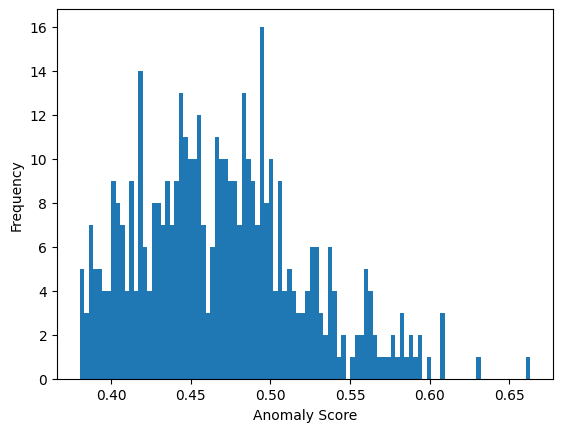

['../models/german/IsolationForest_test.pkl']

In [7]:
outlier_detection = IsolationForest(ndim=1, sample_size=256, max_depth=8, ntrees=100, missing_action="divide")
outlier_detection.fit(X_train);

scores = outlier_detection.predict(X_train)
plt.hist(scores, bins=100);
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()

outlier_detection = OutlierWrap(X_train, outlier_detection, 0.05)
joblib.dump(outlier_detection, "../models/german/IsolationForest.pkl")

outlier_detection = IsolationForest(ndim=1, sample_size=256, max_depth=8, ntrees=100, missing_action="divide")
outlier_detection.fit(X_test);
outlier_detection = OutlierWrap(X_train, outlier_detection, 0.05)
joblib.dump(outlier_detection, "../models/german/IsolationForest_test.pkl")

## Taiwan

In [8]:
os.makedirs("../models/taiwan", exist_ok=True)

In [9]:
df = pd.read_csv("../data/taiwan.csv")
X = df.drop("NoDefaultNextMonth", axis=1)
X = X.astype(int)
Y = df["NoDefaultNextMonth"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_RATIO, random_state=SEED, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=VAL_RATIO, random_state=SEED, shuffle=True)

In [10]:
for model_name in [
    #"LGBMClassifier", 
    "MLPClassifier"
    ]:
    study = optuna.create_study(
       direction="maximize",
    )
    study.optimize(
        lambda trial: objective(trial, hyperparam_spaces[model_name], X_train, Y_train, X_val, Y_val, model_name),
        n_trials=50,
        n_jobs=1,
        show_progress_bar=True,
    )

    params = study.best_params
    if model_name == "LGBMClassifier":
        model = LGBMClassifier(**params)
    elif model_name == "MLPClassifier":
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("classifier", models.MLPClassifier(**params))
        ])
    model.fit(X_train, Y_train)
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    print(f"Number of denied samples from test: {(1 - Y_test_pred).sum():d}")
    print(f"Score  training: {balanced_accuracy_score(Y_train, Y_train_pred):.3f}")
    print(f"Score validation: {balanced_accuracy_score(Y_val, model.predict(X_val)):.3f}")
    print(f"Score  test: {balanced_accuracy_score(Y_test, Y_test_pred):.3f}")

    joblib.dump(model, f"../models/taiwan/{model_name}.pkl")

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [30] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [30, 30] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [30, 30, 30] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but co

Number of denied samples from test: 5416
Score  training: 0.719
Score validation: 0.699
Score  test: 0.701


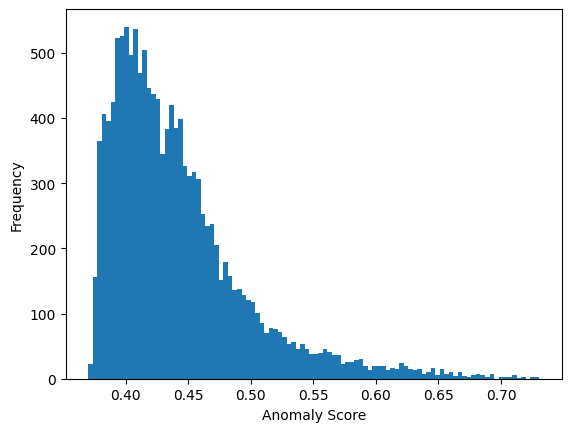

['../models/taiwan/IsolationForest_test.pkl']

In [13]:
outlier_detection = IsolationForest(ndim=1, sample_size=256, max_depth=8, ntrees=100, missing_action="divide")
outlier_detection.fit(X_train);

scores = outlier_detection.predict(X_train)
plt.hist(scores, bins=100);
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()


outlier_detection = OutlierWrap(X_train, outlier_detection, 0.05)
joblib.dump(outlier_detection, "../models/taiwan/IsolationForest.pkl")

outlier_detection = IsolationForest(ndim=1, sample_size=256, max_depth=8, ntrees=100, missing_action="divide")
outlier_detection.fit(X_test);
outlier_detection = OutlierWrap(X_train, outlier_detection, 0.05)
joblib.dump(outlier_detection, "../models/taiwan/IsolationForest_test.pkl")